# Building the Predictive Model

After collecting the data, performing sentiment analysis, and adding feature engineering we are now going to build the predictive models.

## Data Preparation 

In [74]:
import pandas as pd
import numpy as np

In [111]:
# load data
coffee = pd.read_csv("project_data.csv")

In [112]:
coffee.head()

,SearchTrends,Quarterly Revenue (Billions),Closing Price,SMP Close,article_count,comp_sentiment,pos_ratio,neg_ratio,Week Num,Month Num,Quarter,Previous Close,Weekly Close Pct Change,Company
0,64,6.2,98.66,3662.449951,NaN,NaN,NaN,NaN,48,11,4,NaN,0.00,1
1,55,6.2,102.28,3702.250000,NaN,NaN,NaN,NaN,49,12,4,98.66,3.67,1
2,56,6.2,103.00,3694.620117,1.0,0.0,0.0,0.0,50,12,4,102.28,0.70,1
3,55,6.2,103.28,3687.260010,NaN,NaN,NaN,NaN,51,12,4,103.00,0.27,1
4,54,6.7,105.67,3801.189941,NaN,NaN,NaN,NaN,1,1,1,103.28,2.31,1


In [113]:
coffee.dtypes.value_counts() # checking data types

float64    9
int64      5
Name: count, dtype: int64

In [114]:
X = coffee.drop(['Closing Price', 'Previous Close'], axis=1) # drop the target (Closing Price) and the Previous close because that would cause information leak
y = coffee[['Closing Price']]

In [115]:
X.head()

,SearchTrends,Quarterly Revenue (Billions),SMP Close,article_count,comp_sentiment,pos_ratio,neg_ratio,Week Num,Month Num,Quarter,Weekly Close Pct Change,Company
0,64,6.2,3662.449951,NaN,NaN,NaN,NaN,48,11,4,0.00,1
1,55,6.2,3702.250000,NaN,NaN,NaN,NaN,49,12,4,3.67,1
2,56,6.2,3694.620117,1.0,0.0,0.0,0.0,50,12,4,0.70,1
3,55,6.2,3687.260010,NaN,NaN,NaN,NaN,51,12,4,0.27,1
4,54,6.7,3801.189941,NaN,NaN,NaN,NaN,1,1,1,2.31,1


In [116]:
# load the required library
from sklearn.model_selection import train_test_split

# split data into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [117]:
y_train_rf = y_train.squeeze()
y_test_rf = y_test.squeeze()

In [118]:
X_train.shape

(529, 12)

In [119]:
X_test.shape # check that partition worked

(227, 12)

## Modeling and Evaluation

### Model #1: Random Forest

We chose to use a random forest to predict weekly stock price for the fast food coffee industry. Using a random forest and cross validation will improve the predictive accurracy of our model.

In [84]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(
    random_state=100 # set random state for reproducibility
)

# cross-validation grid
grid_param = {
    'n_estimators': [10, 30, 50, 80, 100],
    'max_depth': [None, 5, 10, 20]
} 


In [85]:
# build the model
rf_cv = GridSearchCV(estimator=rf,
                     param_grid=grid_param,
                     scoring='neg_root_mean_squared_error',
                     cv=5,
                     n_jobs=-1)

In [86]:
# fit the model
rf_cv.fit(X_train, y_train_rf)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=100), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'n_estimators': [10, 30, 50, 80, 100]},
             scoring='neg_root_mean_squared_error')

In [87]:
print("Best params:", rf_cv.best_params_)
print("Best score (RMSE):", -rf_cv.best_score_)


Best params: {'max_depth': 20, 'n_estimators': 100}
Best score (RMSE): 9.531127225092323


                         feature  importance
1   Quarterly Revenue (Billions)    0.602273
11                       Company    0.358164
2                      SMP Close    0.028423
7                       Week Num    0.004402
10       Weekly Close Pct Change    0.002565
0                   SearchTrends    0.001611
8                      Month Num    0.001401
9                        Quarter    0.000630
5                      pos_ratio    0.000187
4                 comp_sentiment    0.000163
6                      neg_ratio    0.000144
3                  article_count    0.000038


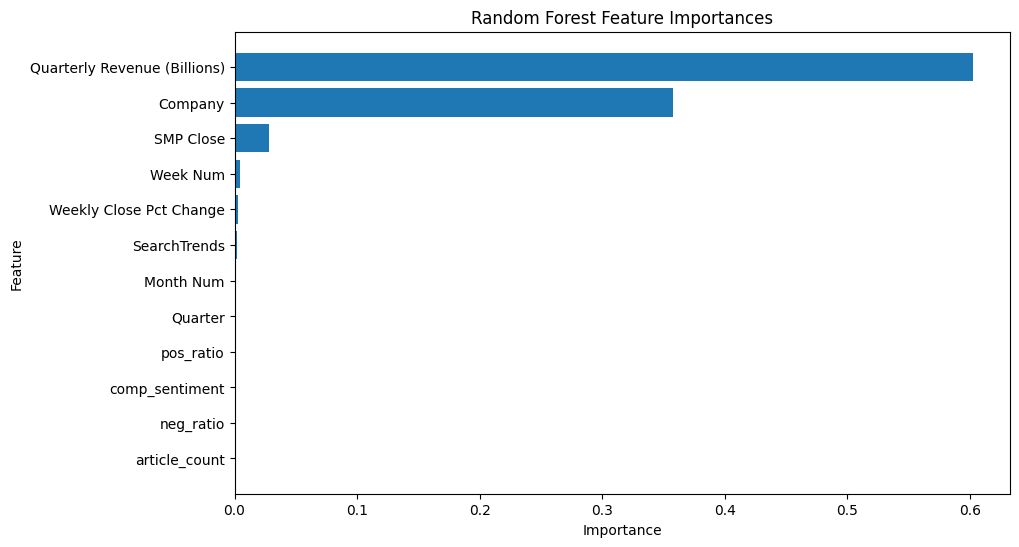

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

# get the best model from GridSearchCV
best_rf = rf_cv.best_estimator_

# get feature importances
importances = best_rf.feature_importances_

feature_names = X_train.columns 

# create a df for easier handling
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# sort by importance
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)
print(feat_imp_df)

# plot of feature importance
plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()


In [89]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

# make predictions on the model and test data
rf_pred = rf_cv.predict(X_test)
residuals = y_test_rf - rf_pred

# calculate performance metrics
mae = mean_absolute_error(y_test_rf, rf_pred)
rmse = root_mean_squared_error(y_test_rf, rf_pred)
r2 = r2_score(y_test_rf, rf_pred)

print("Regression Metrics:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")


Regression Metrics:
MAE:  5.4049
RMSE: 8.0977
R²:   0.9891


### Model #2: Logistic Regression

For our second predictive model, we chose to do logistic regression to predict whether the stock price increases (1) or decreases (0) from the previous week to the current week.

In [120]:
# replacing NA values with the most recent sentiment score
# we cannot perform logistic regression with NA values
coffee['comp_sentiment'] = coffee['comp_sentiment'].fillna(method='ffill').fillna(method='bfill')
coffee['pos_ratio'] = coffee['pos_ratio'].fillna(method='ffill').fillna(method='bfill')
coffee['neg_ratio'] = coffee['neg_ratio'].fillna(method='ffill').fillna(method='bfill')

# replace search trend index and number of articles with 0 if missing
coffee['SearchTrends'] = coffee['SearchTrends'].fillna(0)
coffee['article_count'] = coffee['article_count'].fillna(0)

/tmp/ipykernel_742864/2897219593.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coffee['comp_sentiment'] = coffee['comp_sentiment'].fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_742864/2897219593.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coffee['pos_ratio'] = coffee['pos_ratio'].fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_742864/2897219593.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coffee['neg_ratio'] = coffee['neg_ratio'].fillna(method='ffill').fillna(method='bfill')


In [121]:
# remove any remaining NA
coffee_log = coffee.dropna()

In [122]:
coffee_log.shape
# we only lost one observation, the first, one because there was nothing to backfill

(755, 14)

In [123]:
coffee_log.head()

,SearchTrends,Quarterly Revenue (Billions),Closing Price,SMP Close,article_count,comp_sentiment,pos_ratio,neg_ratio,Week Num,Month Num,Quarter,Previous Close,Weekly Close Pct Change,Company
1,55,6.2,102.28,3702.250000,0.0,0.0,0.0,0.0,49,12,4,98.66,3.67,1
2,56,6.2,103.00,3694.620117,1.0,0.0,0.0,0.0,50,12,4,102.28,0.70,1
3,55,6.2,103.28,3687.260010,0.0,0.0,0.0,0.0,51,12,4,103.00,0.27,1
4,54,6.7,105.67,3801.189941,0.0,0.0,0.0,0.0,1,1,1,103.28,2.31,1
5,50,6.7,102.33,3798.909912,0.0,0.0,0.0,0.0,2,1,1,105.67,-3.16,1


In [124]:
# create binary target: 1 if stock price increases from the previous week, 0 if it decreases
coffee_log['Increase'] = (coffee_log['Weekly Close Pct Change'] > 0).astype(int)
coffee_log = coffee_log.drop(['Weekly Close Pct Change', 'Closing Price'], axis = 1)
# removing Closing Price to prevent information leakage with Previous Close also included

coffee_log.head()


/tmp/ipykernel_742864/588914475.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coffee_log['Increase'] = (coffee_log['Weekly Close Pct Change'] > 0).astype(int)


,SearchTrends,Quarterly Revenue (Billions),SMP Close,article_count,comp_sentiment,pos_ratio,neg_ratio,Week Num,Month Num,Quarter,Previous Close,Company,Increase
1,55,6.2,3702.250000,0.0,0.0,0.0,0.0,49,12,4,98.66,1,1
2,56,6.2,3694.620117,1.0,0.0,0.0,0.0,50,12,4,102.28,1,1
3,55,6.2,3687.260010,0.0,0.0,0.0,0.0,51,12,4,103.00,1,1
4,54,6.7,3801.189941,0.0,0.0,0.0,0.0,1,1,1,103.28,1,1
5,50,6.7,3798.909912,0.0,0.0,0.0,0.0,2,1,1,105.67,1,0


In [95]:
from sklearn.model_selection import train_test_split

# separate features and target
X_log = coffee_log.drop(['Increase'], axis=1) 
y_log = coffee_log['Increase']

# training and test split with random state for reproducibility
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.3, random_state=100)

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# pipeline to scale the data and then fit the log regression model
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=100)) # random state for reproducibility
])

# hyperparameter grid for cross-validation
param_grid = {
    'logreg__penalty': ['l1', 'l2', 'elasticnet'],
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__solver': ['liblinear', 'saga'],
    'logreg__max_iter': [500, 1000, 2000],
    'logreg__l1_ratio': [0, 0.5, 1.0]
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

# fit the model!
grid.fit(X_train_log, y_train_log)


/opt/tljh/user/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/tljh/user/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/tljh/user/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/tljh/user/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/tljh/user/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/tljh/user/lib/python3.12/site-

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(random_state=100))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'logreg__l1_ratio': [0, 0.5, 1.0],
                         'logreg__max_iter': [500, 1000, 2000],
                         'logreg__penalty': ['l1', 'l2', 'elasticnet'],
                         'logreg__solver': ['liblinear', 'saga']},
             scoring='roc_auc')

In [97]:
print(grid.best_estimator_.named_steps['logreg'])
# return the best tuned parameters

LogisticRegression(C=1, l1_ratio=0, max_iter=500, random_state=100,
                   solver='liblinear')


In [98]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# predict on the model
y_pred = grid.predict(X_test_log)

print(accuracy_score(y_test_log, y_pred))
print("")
print(confusion_matrix(y_test_log, y_pred))  
print(classification_report(y_test_log, y_pred)) 

0.47577092511013214

[[43 47]
 [72 65]]
              precision    recall  f1-score   support

           0       0.37      0.48      0.42        90
           1       0.58      0.47      0.52       137

    accuracy                           0.48       227
   macro avg       0.48      0.48      0.47       227
weighted avg       0.50      0.48      0.48       227



### Model #3: Neural Network

We decided to also fit a Neural Network for binary classification to see if it would perform better than the logistic regression.

In [99]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# setting random seeds for reproducibility
torch.manual_seed(100)
np.random.seed(100)
random.seed(100)

In [100]:
scaler = StandardScaler()
X_train_log = scaler.fit_transform(X_train_log)
X_test_log = scaler.transform(X_test_log)
# scale predictor variables between 0 and 1, as neural networks require

# convert data types to tensor
X_train_log = torch.tensor(X_train_log, dtype=torch.float32)
X_test_log = torch.tensor(X_test_log, dtype=torch.float32)

y_train_log = torch.tensor(y_train_log.values, dtype=torch.long)
y_test_log = torch.tensor(y_test_log.values, dtype=torch.long)


In [101]:
# building neural network including cross-validation

import torch
import torch.nn as nn
import torch.nn.functional as F

# establish the layers and inputs for the neural net
class BinaryNN(nn.Module):
    def __init__(self, input_dim, hidden1=32, hidden2=16, dropout1=0.3, dropout2=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 1)
        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)


In [102]:
from skorch import NeuralNetBinaryClassifier
import torch.optim as optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# build the initial structure of the neural net
net = NeuralNetBinaryClassifier(
    module=BinaryNN,
    module__input_dim=X_train_log.shape[1],
    max_epochs=20,
    lr=0.001,
    optimizer=optim.Adam,
    criterion=nn.BCEWithLogitsLoss,
    optimizer__weight_decay=0.0,
    batch_size=64,
    iterator_train__shuffle=True,
    train_split=None,
    verbose=0,
    device=device
)


In [103]:
from sklearn.model_selection import GridSearchCV, KFold

# establish grid for cross-validation
params = {
    'module__hidden1': [16, 32, 64],
    'module__hidden2': [8, 16, 32],
    'module__dropout1': [0.1, 0.2],
    'module__dropout2': [0.1, 0.2],
    'lr': [0.001, 0.0005],
    'optimizer__weight_decay': [0.0, 0.0001, 0.001],
    'max_epochs': [20, 40, 60],
    'batch_size': [32, 64, 128],
}

cv = KFold(n_splits=3, shuffle=True, random_state=100)

# cross-validate on the model parameters, optimizing AUC
gs = GridSearchCV(
    estimator=net,
    param_grid=params,
    scoring='roc_auc',
    cv=cv,
    refit=True,
    verbose=1
)



In [104]:
y_train_log = y_train_log.float()
y_test_log = y_test_log.float()

In [105]:
gs.fit(X_train_log.numpy(), y_train_log.numpy())
# fit the model with training data converted to numpy arrays

Fitting 3 folds for each of 1944 candidates, totalling 5832 fits


/opt/tljh/user/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=KFold(n_splits=3, random_state=100, shuffle=True),
             estimator=NeuralNetBinaryClassifier(_params_to_validate={'module__input_dim', 'optimizer__weight_decay', 'iterator_train__shuffle'}, batch_size=64, callbacks=None, compile=False, dataset=<class 'skorch.dataset.Dataset'>, device='cpu', iterator_train=<class 'torch.utils.data.dataloader.DataLoader...oad_kwargs=None, train_split=None, use_caching='auto', verbose=0, warm_start=False),
             param_grid={'batch_size': [32, 64, 128], 'lr': [0.001, 0.0005],
                         'max_epochs': [20, 40, 60],
                         'module__dropout1': [0.1, 0.2],
                         'module__dropout2': [0.1, 0.2],
                         'module__hidden1': [16, 32, 64],
                         'module__hidden2': [8, 16, 32],
                         'optimizer__weight_decay': [0.0, 0.0001, 0.001]},
             scoring='roc_auc', verbose=1)

In [106]:
best_model = gs.best_estimator_
print(best_model)
# return the best model and hyperparameters
print(gs.best_params_)

<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=BinaryNN(
    (fc1): Linear(in_features=12, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=1, bias=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  ),
)
{'batch_size': 32, 'lr': 0.001, 'max_epochs': 60, 'module__dropout1': 0.1, 'module__dropout2': 0.1, 'module__hidden1': 64, 'module__hidden2': 32, 'optimizer__weight_decay': 0.0}


In [107]:
import joblib

# save the neural net model to a pickle as a backup
joblib.dump(gs, "neural_net2.pkl")


['neural_net2.pkl']

#### evaluate neural net

In [108]:
grid = joblib.load("neural_net2.pkl")

# assign best model to variable for predictions
model = grid.best_estimator_

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

# skorch expects numpy arrays
X_test_np = X_test_log.numpy()
y_test_np = y_test_log.numpy()

# get predictions
probs = best_model.predict_proba(X_test_np)[:, 1] # probability of class 1
preds = best_model.predict(X_test_np)

print("Accuracy:", accuracy_score(y_test_np, preds))
print("Precision:", precision_score(y_test_np, preds))
print("Recall:", recall_score(y_test_np, preds))
print("\n")
print("F1 Score:", f1_score(y_test_np, preds))
print("ROC-AUC:", roc_auc_score(y_test_np, probs))
print("\n")
print("Confusion Matrix:\n", confusion_matrix(y_test_np, preds))


Accuracy: 0.4933920704845815
Precision: 0.5873015873015873
Recall: 0.5401459854014599


F1 Score: 0.5627376425855514
ROC-AUC: 0.47964314679643144


Confusion Matrix:
 [[38 52]
 [63 74]]


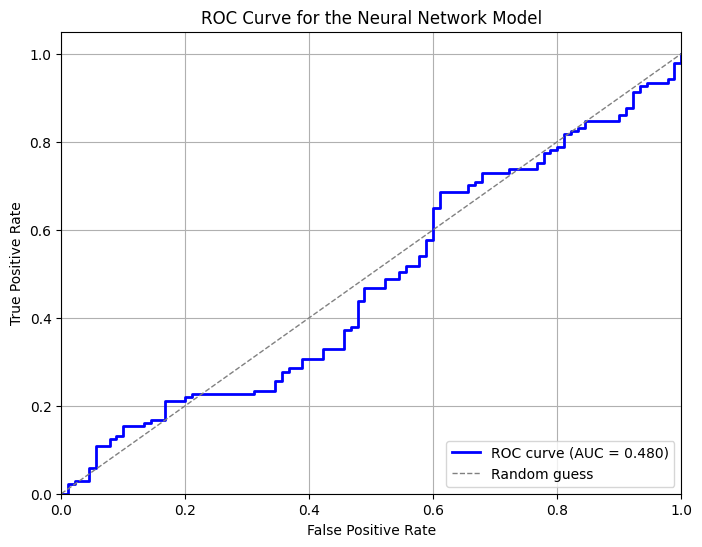

In [109]:
# plotting ROC/AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test_np, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for the Neural Network Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()